# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains a malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
current_dir= os.getcwd()

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:

work_dir = os.getcwd()
work_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\MalariaDetector'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [7]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Parasitized', 'Uninfected']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(129, 129, 3)

---

# Number of images in train, test and validation data

* train - Parasitized: 3950 images
* train - Uninfected: 3950 images
* validation - Parasitized: 564 images
* validation - Uninfected: 564 images
* test - Parasitized: 1129 images
* test - Uninfected: 1129 images




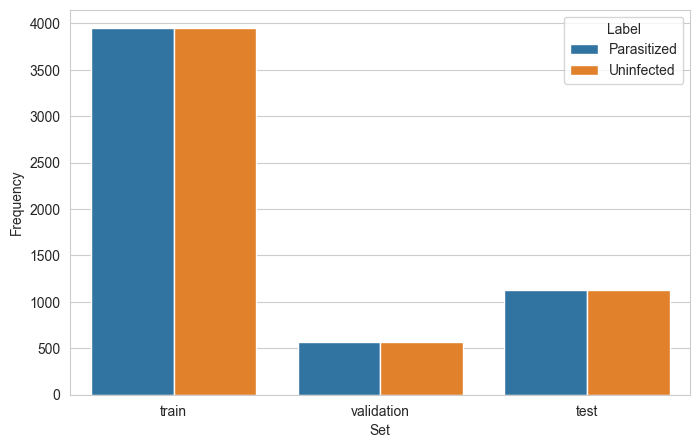

In [10]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

Number of imaages is only moderate. For deep learning we need a large amount of data though -> Image augmentation, to get more data

---

# Image data augmentation

---

### ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

* ### Augment training image dataset

In [ ]:
batch_size = 20  # Set batch size

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 7900 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

The ImageDataGenerator creates augmented images on the fly — that means, during training it takes your original images and applies random transformations each epoch.

So the model sees a slightly different version of each image every time it goes through the data, but:

⚠️ These new images are not saved on disk.

⚙️ They are generated in memory temporarily.

📊 Your dataset size on disk does not change, but effectively the model trains on more diverse data.

* ### Augment validation image dataset

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 1128 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment test image dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 2258 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

We only apply data augmentation to the training set because it helps the model learn to generalize by seeing varied versions of the data.
The validation and test sets are used to evaluate the model’s performance, so they must stay unchanged — otherwise, the results would be random and unreliable.
We only rescale them to keep the input values consistent with the training data.

## Plot augmented training image

(20, 129, 129, 3)


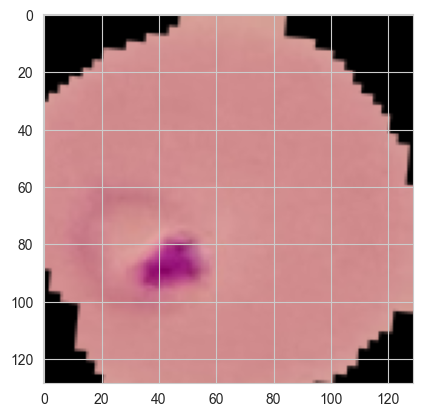

(20, 129, 129, 3)


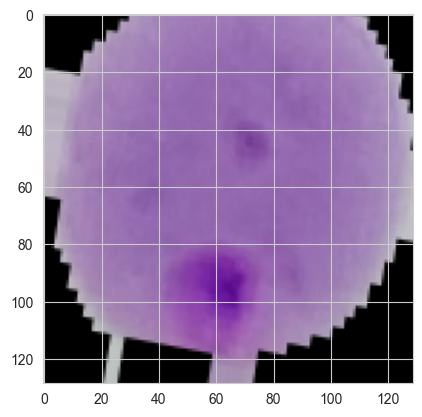

(20, 129, 129, 3)


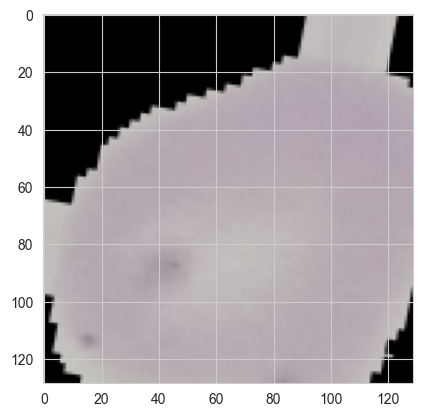

In [21]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 129, 129, 3)


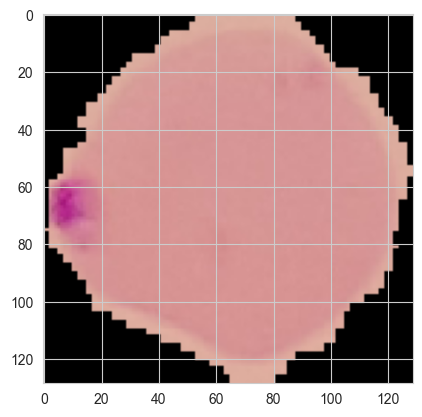

(20, 129, 129, 3)


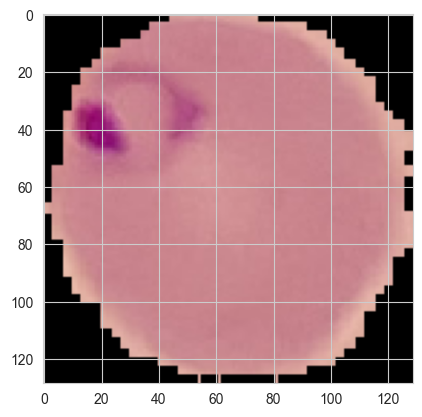

(20, 129, 129, 3)


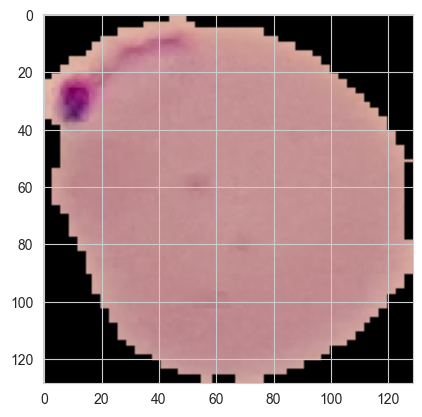

In [19]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 129, 129, 3)


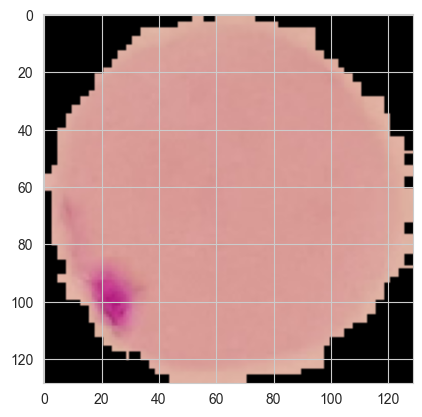

(20, 129, 129, 3)


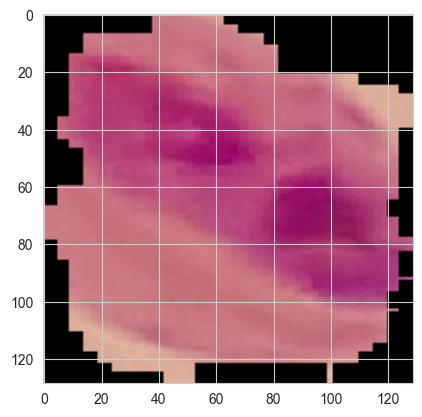

(20, 129, 129, 3)


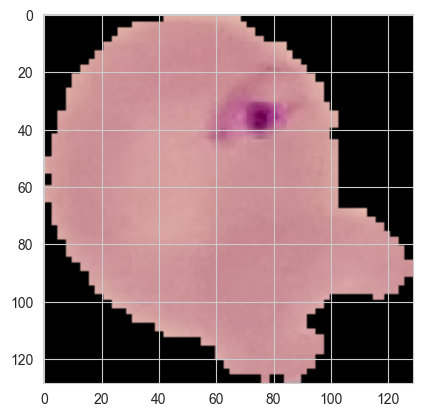

In [20]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [26]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Conv2D: applies 32 filters of size 3×3 over the image to detect low-level features.
    # activation='relu': keeps only positive activations → adds nonlinearity.
    # MaxPooling2D: reduces the image size by taking the strongest (max) signal in each 
    # 2×2 region → reduces parameters and overfitting.
    # -> The combination of these two layers removes the nonessential part of the image 
    # and reduces complexity, therefore providing more accuracy.

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # Flatten() converts the 2D feature maps into a 1D vector.
    # Dense(128) creates a fully connected layer that combines the learned features into higher-level representations.

    model.add(Dropout(0.5))
    # Randomly drops 50 % of neurons during training → prevents overfitting by forcing the model to learn more robust patterns.
    model.add(Dense(1, activation='sigmoid'))
    # 1 neuron + sigmoid → outputs a probability between 0 and 1 for binary classification.

    model.compile(loss='binary_crossentropy', # standard for 2 classes
                  optimizer='adam', # adjusts weights efficiently
                  metrics=['accuracy', "Recall"]) # shows how well it performs in practice
    # track for recall as well because we want to avoid false negatives

    return model


* ### Model Summary 

In [25]:
create_tf_model().summary()

c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\MalariaDetector\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,209 (6.34 MB)

 Trainable params: 1,662,209 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping 

stop the model training in the situation of
overfitting or underfitting of the model.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [28]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\MalariaDetector\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 112s 273ms/step - Recall: 0.8192 - accuracy: 0.7289 - loss: 0.5308 - val_Recall: 0.9929 - val_accuracy: 0.9211 - val_loss: 0.2457
Epoch 2/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 87s 220ms/step - Recall: 0.9575 - accuracy: 0.8897 - loss: 0.3364 - val_Recall: 0.9929 - val_accuracy: 0.9557 - val_loss: 0.1584
Epoch 3/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - Recall: 0.9762 - accuracy: 0.9395 - loss: 0.2119 - val_Recall: 0.9539 - val_accuracy: 0.9512 - val_loss: 0.1598
Epoch 4/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 3196s 8s/step - Recall: 0.9729 - accuracy: 0.9480 - loss: 0.1809 - val_Recall: 0.9787 - val_accuracy: 0.9610 - val_loss: 0.1192
Epoch 5/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 100s 254ms/step - Recall: 0.9661 - accuracy: 0.9494 - loss: 0.1687 - val_Recall: 0.9805 - val_accuracy: 0.9663 - val_loss: 0.1069
Epoch 6/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 269ms/step - Recall: 0.9663 - accuracy: 0.9489 - loss: 0.1681 - val_Recall: 0.9699 - val_accuracy: 0.9654 - v

## Save model

In [29]:
model.save('outputs/v1/malaria_detector_model.h5')

---

# Model Performace

---

## Model learning curve

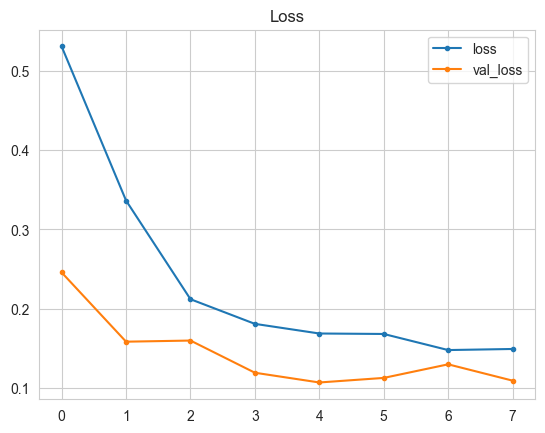

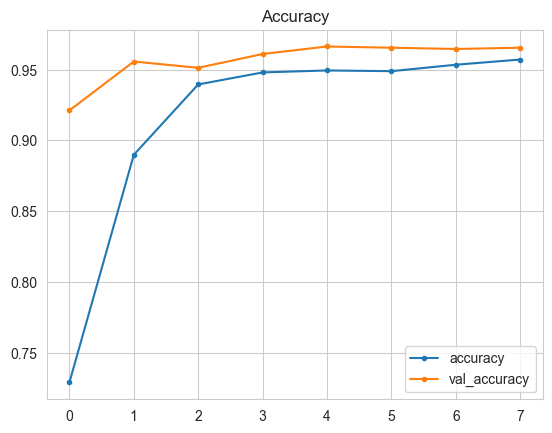

In [30]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [31]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Evaluate model on test set

In [32]:
evaluation = model.evaluate(test_set)


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\MalariaDetector\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 74s 651ms/step - accuracy: 0.9677 - loss: 0.1053 - recall_1: 0.9734


### Save evaluation pickle

In [33]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (129, 129), Image mode: RGB


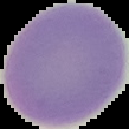

In [37]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [38]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 129, 129, 3)


Predict class probabilities

In [39]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.9855652
Uninfected


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [42]:
!type .gitignore #?

inputs/
kaggle.json
*.ipynb
__pycache__/




.gitignore


The system cannot find the file specified.
Error occurred while processing: #?.


* Git status

In [41]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/class_indices.pkl
	outputs/v1/evaluation.pkl
	outputs/v1/labels_distribution.png
	outputs/v1/malaria_detector_model.h5
	outputs/v1/model_training_acc.png
	outputs/v1/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [43]:
!git add .

* Git commit

In [ ]:
!git commit -am " Add new plots"

* Git Push

In [ ]:
!git push

---